In [23]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Testes de processamento de imagens

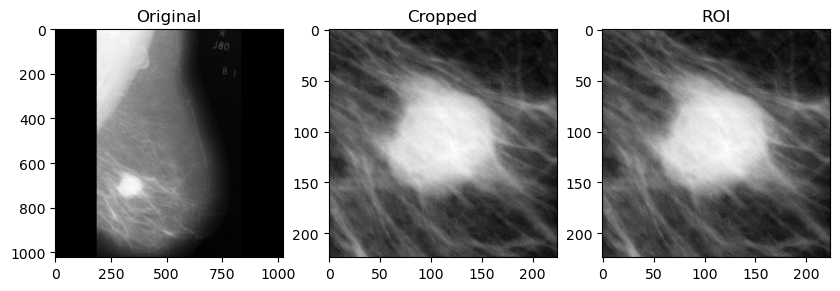

In [26]:
df = pd.read_csv("../../outputs/mamografia/mias/metadata_mias.csv")

idx = 28
df_one = df.iloc[idx]

radius = int(df_one["radius"])
x, y = df_one["x_center_abnormality"], df_one["y_center_abnormality"]
x, y = int(x), (1024 - int(y))
x_start, x_end = x - radius * 2, x + radius * 2
y_start, y_end = y - radius * 2, y + radius * 2

image = cv2.imread(df.iloc[idx]["image_path"], cv2.IMREAD_GRAYSCALE)
cropp1 = cv2.imread(df.iloc[idx]["cropped_image_path"], cv2.IMREAD_GRAYSCALE)
roi = cv2.imread(df.iloc[idx]["roi_image_path"], cv2.IMREAD_GRAYSCALE)

arr_tmps = []
if x_start < 0:
    arr_tmps.append(0)
    x_start = 0
if x_end > image.shape[1]:
    arr_tmps.append(1)
    x_end = 1024
if y_start < 0:
    arr_tmps.append(2)
    y_start = 0
if y_end > image.shape[0]:
    arr_tmps.append(3)
    y_end = 1024

cropp = image[y_start: y_end, x_start:x_end]

if 0 in arr_tmps:
    tmp = np.zeros((cropp.shape[0], abs(x_start - 0)))
    cropp = np.hstack((tmp, cropp))
if 1 in arr_tmps:
    tmp = np.zeros((cropp.shape[0], x_end - 1024))
    cropp = np.hstack((cropp, tmp))
if 2 in arr_tmps:
    tmp = np.zeros((abs((y - radius * 2) - 0), cropp.shape[1]))
    cropp = np.vstack((tmp, cropp))
if 3 in arr_tmps:
    tmp = np.zeros((y_end - 1024, cropp.shape[1]))
    cropp = np.vstack((cropp, tmp))

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image, cmap="gray")
axs[0].set_title("Original")

axs[1].imshow(cropp, cmap="gray")
axs[1].set_title("Cropped")

axs[2].imshow(cropp1, cmap="gray")
axs[2].set_title("ROI")

plt.show()